<img src=mainfoto.jpg width=1500px height=300px> 

# <center> <strong> АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

#### <strong> Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные. 

#### <strong> Необходимо проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

#### <strong> A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?

## 1. Анализ данных и  их предобработка.

In [1]:
# Импортируем библиотеки для работы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.stats.proportion import proportions_ztest,proportion_confint
from scipy import stats
from scipy.stats import norm,t

In [2]:
# Вносим наш датасет в переменную

ab_data = pd.read_csv('ab_data_tourist.csv')
print(ab_data.shape)
ab_data.head(2)


(294478, 5)


,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0


Наша таблица представлена следующими полями:

        user_id — идентификатор пользователя, зашедшего на сайт;
        data — дата посещения сайта;
        group — группа теста (контрольная — А или тестовая — B);
        purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
        price — цена купленного тура (если покупка не состоялась, цена равна 0).


Видим, что размер нашего датасета чуть меньше 300 тыс. наблюдений и 5 столбцов, описание которых выше.

In [3]:
# Проверим датасет на наличие пропусков и типа данных в столбцах. 
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


В данных отсутствуют пропуски.

In [4]:
# Преобразуем столбец с датой в формат datetime.
ab_data['date'] = pd.to_datetime(ab_data['date'],format='%Y-%m-%d')
ab_data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Дата стоит не по порядку, для дальнейшей работы это необходимо исправить. Отфильтруем дату в порядке убывания.

In [5]:
ab_data.sort_values(by='date',ignore_index=True,inplace=True)
ab_data

,user_id,date,group,purchase,price
0,637212,2021-01-02,B,1,100000
1,924138,2021-01-02,B,0,0
2,659091,2021-01-02,A,0,0
3,653194,2021-01-02,B,0,0
4,810044,2021-01-02,A,0,0
...,...,...,...,...,...
294473,907259,2021-01-24,A,1,60000
294474,820211,2021-01-24,A,0,0
294475,694025,2021-01-24,B,0,0
294476,763379,2021-01-24,B,0,0


Исправили. Для правдоподобности теста необходимо проверить общую длительность каждого теста, что бы все было справедливо и реально.

In [6]:
# Даты начала двух тестов и количество дней процесса
print('количество дней шло тестирование в группе А : {}'.format(ab_data[ab_data['group']=='A']['date'].nunique()))
print('количество дней шло тестирование в группе B : {}'.format(ab_data[ab_data['group']=='B']['date'].nunique()))
print('--------------------------------------------------')
print('дата начала теста')
display(ab_data.groupby('group')['date'].first())
print('     ')
print('дата конца теста')
ab_data.groupby('group')['date'].last()

количество дней шло тестирование в группе А : 23
количество дней шло тестирование в группе B : 23
--------------------------------------------------
дата начала теста


group
A   2021-01-02
B   2021-01-02
Name: date, dtype: datetime64[ns]

     
дата конца теста


group
A   2021-01-24
B   2021-01-24
Name: date, dtype: datetime64[ns]

По датасету видно, что тесты проходили в один период времени и одинаковое количество дней. Уточним количество наблюдений в каждой группе.

In [7]:
n_A = ab_data[ab_data['group']=='A'].shape[0]
n_B = ab_data[ab_data['group']=='B'].shape[0]

print('Количество посещений сайта в группе А: {}'.format(n_A))
print('Количество посещений сайта в группе B: {}'.format(n_B))

Количество посещений сайта в группе А: 147202
Количество посещений сайта в группе B: 147276


Составы групп сбалансированы. Проверим, а есть ли пользователи, которые случайным образом попали в обе группы и сколько таких, если имеется?

In [8]:
# Воспользуемся свойством множества и выделим в каждой группе уникальных пользователей, 
unique_user_A = set(ab_data[ab_data['group']=='A']['user_id'])
unique_user_B = set(ab_data[ab_data['group']=='B']['user_id'])

# Дальше проверим пересечение двух групп.
interception_group = unique_user_A.intersection(unique_user_B)
# уточним количество пользователей.
print('Количество пользователей, которые попали в обе группы:', len(interception_group))

Количество пользователей, которые попали в обе группы: 1895


Да уж, действительно такие люди в наших группах присутствуют и не мало. Необходимо удалить таких пользователей с двух групп сразу и записать датасет уже в новую переменную.

In [9]:
ab_data_del_dubl = ab_data[~ab_data['user_id'].isin(interception_group)]

## 2. Первичный анализ результатов A/B-тестирования:

Рассчитаем вспомогательные показатели для контрольной и тестовой групп:

*  количество посещений сайта;
*  суммарное количество совершённых покупок;
*  сумма всех покупок.


In [10]:
# Разобьем наши данные по группам, что бы в дальнейшем было проще к ним обращаться.
group_A = ab_data_del_dubl[ab_data_del_dubl['group']=='A']
group_B = ab_data_del_dubl[ab_data_del_dubl['group']=='B']

In [11]:
# сгруппируем наш датасет разбив нужную нам информацию по группам.
ab_table = ab_data_del_dubl.groupby('group'
                         )[['user_id','purchase','price']
                           ].agg(func={'user_id':'count','purchase':'sum','price':'sum'}
                                 ).rename(columns={'user_id':'number_of_visits','purchase':'number_of_purchases','price':'total_sum'})
ab_table

,number_of_visits,number_of_purchases,total_sum
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Видим, что у нас количество посещений почти одинаковое. Количество покупок тоже,но суммы в двух группах разнятся. Возможно именно это решит исход данного теста. В общем группы сбалансированы.

В каждой из групп рассчитаем ключевые показатели, из-за которых мы и затеяли данный тест:

*  конверсия;
*  средний чек.


In [12]:
# Конверсия, округленная до двух знаков в процентом соотношении.
ab_table['total_conversion'] = np.round(ab_table['number_of_purchases']*100/ab_table['number_of_visits'],2)

# Средний чек за все время теста.
ab_table['average_test_check'] = np.round(ab_table['total_sum']/ab_table['number_of_purchases'])

ab_table


,number_of_visits,number_of_purchases,total_sum,total_conversion,average_test_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Видим, что в первой группе выше показатель конверсии, но ниже показатель среднего чека. Необходимо построить сводную таблицу, где мы наглядно увидим, какие суммы покупок преобладают в каждой группе.

In [13]:
ab_data_del_dubl[ab_data_del_dubl['price']!=0].pivot_table(columns='price',index='group',values='purchase',aggfunc='sum')

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


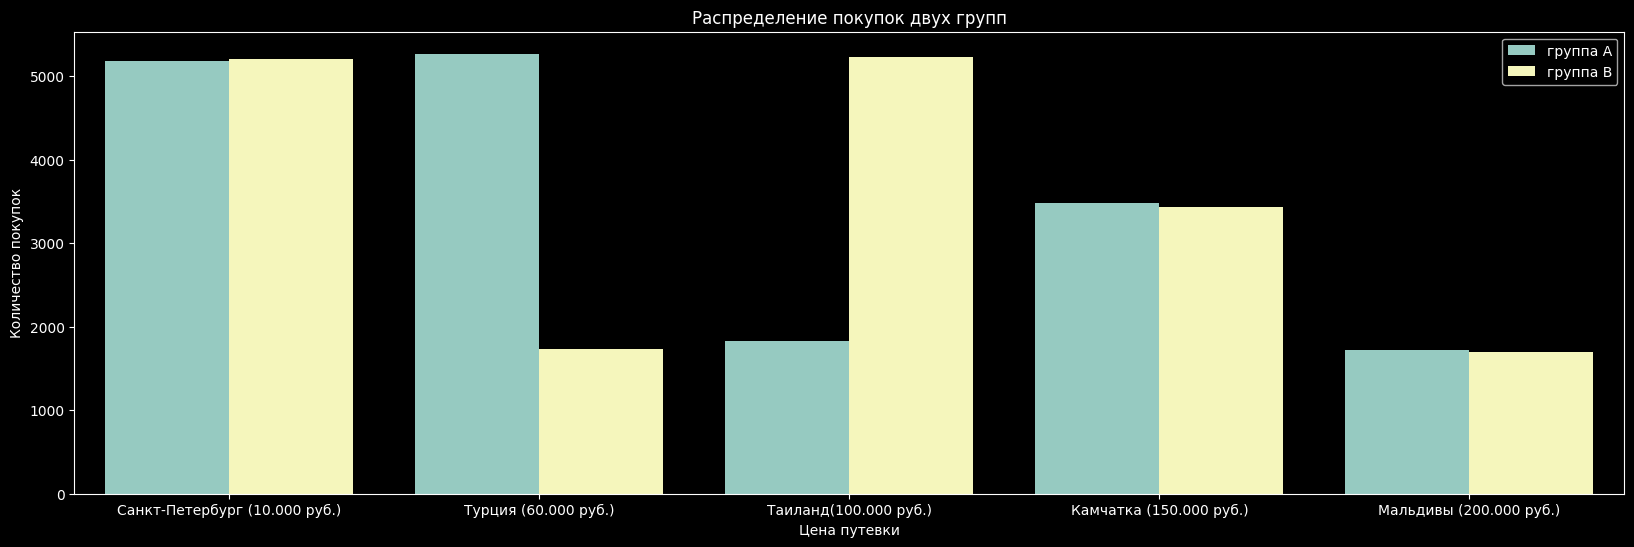

In [14]:
fig,ax = plt.subplots(figsize=(20,6))
sns.countplot(data=ab_data_del_dubl[ab_data_del_dubl['price']!=0],x='price',hue='group')
ax.set_title('Распределение покупок двух групп')
ax.legend(['группа А', 'группа B'])
ax.set_xlabel('Цена путевки')
ax.set_ylabel('Количество покупок');
ax.set_xticks([0,1,2,3,4],['Санкт-Петербург (10.000 руб.)','Турция (60.000 руб.)','Таиланд(100.000 руб.)','Камчатка (150.000 руб.)','Мальдивы (200.000 руб.)'])
plt.show()

На данный момент анализа можно сделать следующие выводы:
1. У нас сбалансированные группы и количества посещений сайта.
2. Конверсия разнится в 1%, причем у первой группы она выше, это говорит о том, что люди чаще покупают путевки.
3. Средний чек нам говорит , что во второй группе, хоть и показатель конверсии ниже, люди больше проводят время на сайте и покупают путевки более дорогие.
4. На графике как раз мы видим где произошел рост покупок. Если в трех из пяти направлениях группы равны в количестве покупок, то разница в количестве покупок путевок за 60 тыс в Турцию и путевок за 100 тыс. в Тайланд разная. Тут у первой группы выделяются путевки более дешевые, а у второй группы мы видим покупки более дорогих.

## 3. Анализ данных на предмет стабилизации метрик:

Нам необходимо проверить комулятивные метрики, как они себя ведут и можно ли считать, что они стабилизировались? A/B-тест завершенным? 


Сгруппируем данные по дате и группе тестирования и построим таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислим ежедневные показатели:

*  количество посещений страницы;
*  количество покупок;
*  сумму покупок.

 

In [15]:
ab_daily_table = ab_data_del_dubl.groupby(
    ['date','group'],as_index=False)[
        ['user_id','purchase','price']].agg(
            func={'user_id':'count','purchase':'sum','price':'sum'}).rename(
                columns={'user_id':'number_of_visits','purchase':'number_of_purchases','price':'total_sum'})
# Добавим так же ежедневный средний чек.

ab_daily_table['average_check_test'] = np.round(ab_daily_table['total_sum']/ab_daily_table['number_of_purchases'],2)
ab_daily_table.head()


,date,group,number_of_visits,number_of_purchases,total_sum,average_check_test
0,2021-01-02,A,2854,359,29410000,81922.01
1,2021-01-02,B,2861,345,29660000,85971.01
2,2021-01-03,A,6596,748,62000000,82887.70
3,2021-01-03,B,6619,754,65960000,87480.11
4,2021-01-04,A,6566,799,64250000,80413.02




Рассчитаем кумулятивные показатели:

*  кумулятивное количество посещений страницы;
*  кумулятивное количество покупок;
*  кумулятивную сумму покупок.





<strong>Кумулятивная метрика</strong>  — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

In [16]:
ab_daily_table['comulative_number_of_visits'] = ab_daily_table.groupby('group')['number_of_visits'].cumsum()
ab_daily_table['comulative_number_of_purchases'] = ab_daily_table.groupby('group')['number_of_purchases'].cumsum()
ab_daily_table['comulative_total_sum'] = ab_daily_table.groupby('group')['total_sum'].cumsum()

ab_daily_table.head()

,date,group,number_of_visits,number_of_purchases,total_sum,average_check_test,comulative_number_of_visits,comulative_number_of_purchases,comulative_total_sum
0,2021-01-02,A,2854,359,29410000,81922.01,2854,359,29410000
1,2021-01-02,B,2861,345,29660000,85971.01,2861,345,29660000
2,2021-01-03,A,6596,748,62000000,82887.70,9450,1107,91410000
3,2021-01-03,B,6619,754,65960000,87480.11,9480,1099,95620000
4,2021-01-04,A,6566,799,64250000,80413.02,16016,1906,155660000


Добавляем в нашу таблицу комулятивные данные конверсии и среднего чека. И посмотрим на графике, что у нас получилось.

In [17]:
ab_daily_table['comulative_conversion'] = ab_daily_table['comulative_number_of_purchases']/ab_daily_table['comulative_number_of_visits']
ab_daily_table['comulative_average_check_test'] = ab_daily_table['comulative_total_sum']/ab_daily_table['comulative_number_of_purchases']

ab_daily_table.head()

,date,group,number_of_visits,number_of_purchases,total_sum,average_check_test,comulative_number_of_visits,comulative_number_of_purchases,comulative_total_sum,comulative_conversion,comulative_average_check_test
0,2021-01-02,A,2854,359,29410000,81922.01,2854,359,29410000,0.125788,81922.005571
1,2021-01-02,B,2861,345,29660000,85971.01,2861,345,29660000,0.120587,85971.014493
2,2021-01-03,A,6596,748,62000000,82887.70,9450,1107,91410000,0.117143,82574.525745
3,2021-01-03,B,6619,754,65960000,87480.11,9480,1099,95620000,0.115928,87006.369427
4,2021-01-04,A,6566,799,64250000,80413.02,16016,1906,155660000,0.119006,81668.415530


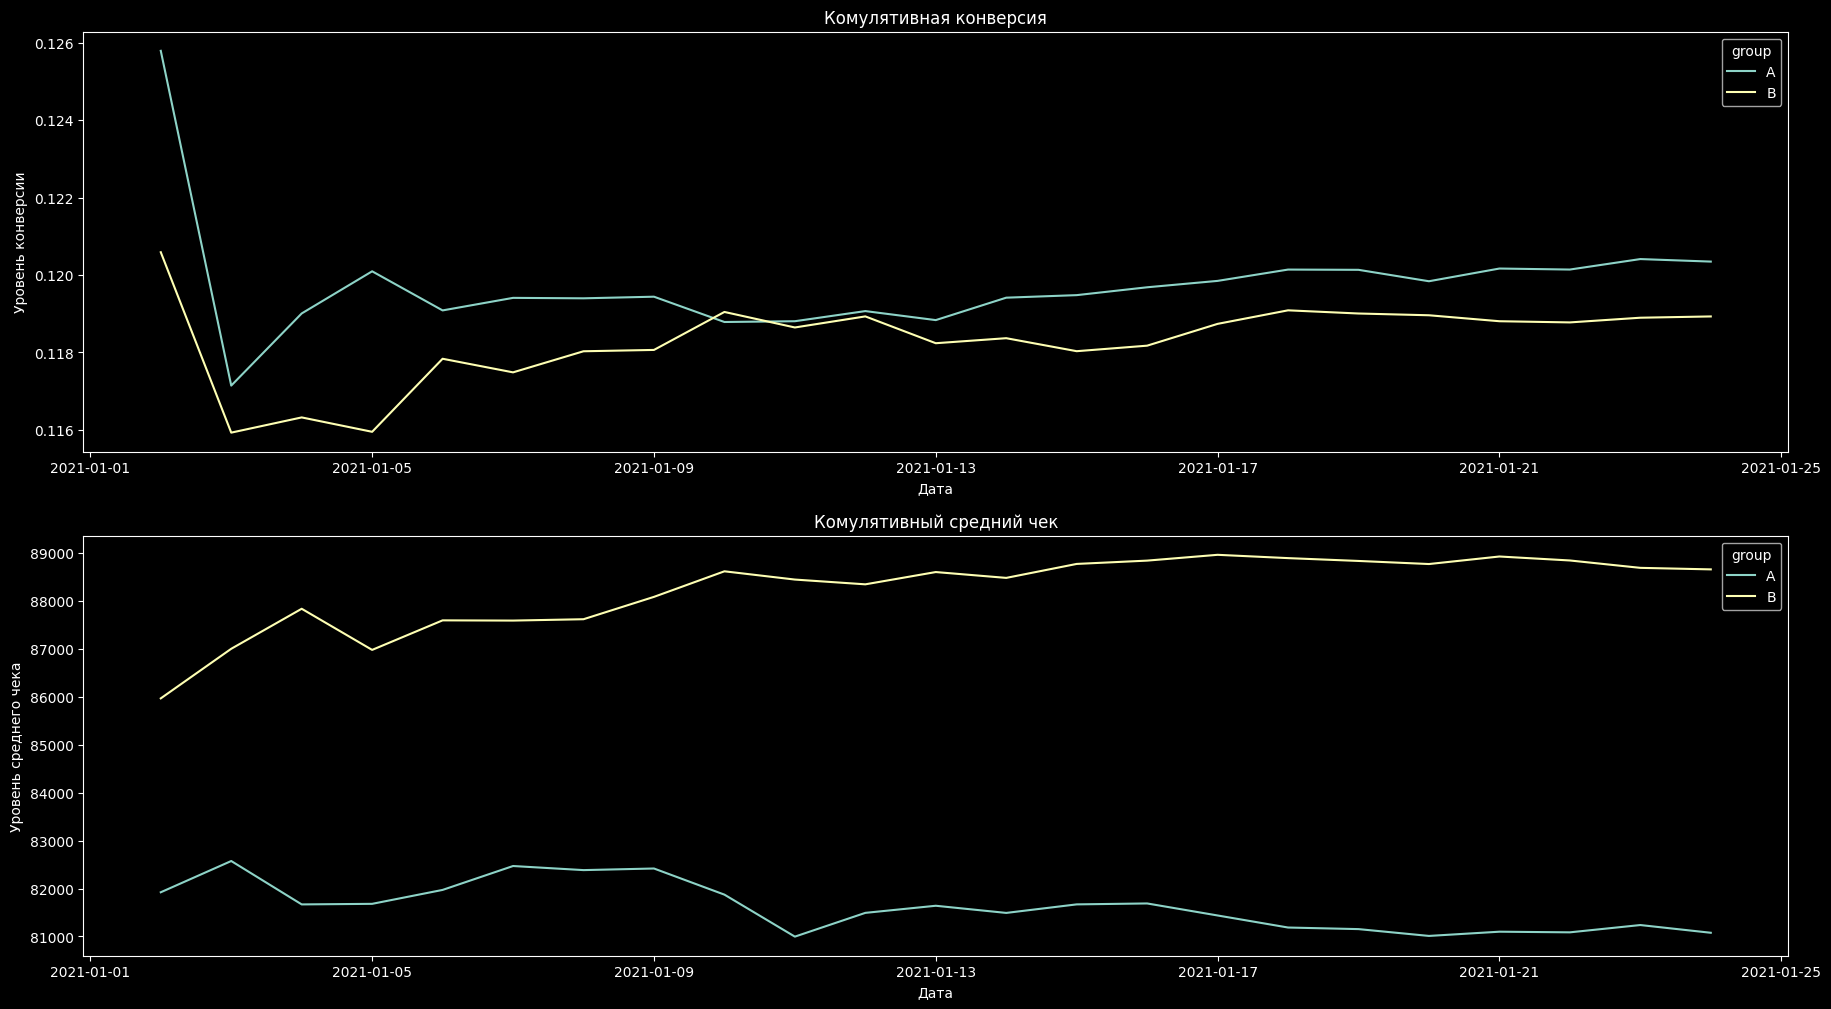

In [18]:
fig,ax = plt.subplots(2,1,figsize = (22,12))
sns.lineplot(ab_daily_table,x='date',y='comulative_conversion',hue='group',ax=ax[0])
ax[0].set_title('Комулятивная конверсия')
ax[0].set_xlabel('Дата')
ax[0].set_ylabel('Уровень конверсии')

sns.lineplot(ab_daily_table,x='date',y='comulative_average_check_test',hue='group',ax=ax[1])
ax[1].set_title('Комулятивный средний чек')
ax[1].set_xlabel('Дата')
ax[1].set_ylabel('Уровень среднего чека')
plt.show()

Можем ответить на вопрос, можно ли назвать тест завершенным? Да, можно, метрики стабилизированы. Как и ранее было замечено, конверсия выше в первой группе, а во второй группе выше средний чек.

## 4. Проведение статистического анализа результатов A/B-тестирования:

Первое, начнем с конверсии:

Итак у нас есть две независимых группы: пользователи в группах A и B не пересекаются. Будем использовать Z-тест для пропорций.

* Нулевая гипотеза: разница пропорций в группах A и B равна некоторому заранее заданному числу value.

* Альтернативная гипотеза: разница пропорций в группах A и B не равна некоторому заранее заданному числу value.


Т.к. по умолчанию $value = 0$ то гипотезы будут иметь вид:
* Нулевая гипотеза:  пропорции в группах A и B равны 
#### $$H0: p_a = p_b$$ 

* Альтернативная гипотеза: пропорции групп A и B не равны
#### $$H1: p_a \neq p_b$$ 





Для теста нам необходимы следующие данные:
* Общее число успехов по каждой группе
* Общее число наблюдений по двум группам
* Вид гипотезы, в данном случае она двухсторонняя

In [19]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=ab_table['number_of_purchases'], #число «успехов» выбирается по всем группам общее число успехов
    nobs=ab_table['number_of_visits'], #общее число наблюдений, по двум группам
    alternative='two-sided') # вид гипотезы, в данном случае двухсторонняя 'smaller' — левосторонняя, 'larger' — правосторонняя
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу") 

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


Z -тест нам показал, что у нас нет оснований отвергать нулевую гипотезу, а значит разницы между двумя типами сайтов по метрике конверсии нет. 

А что насчет метрики среднего чека... Давайте сделаем статистический тест , что бы выяснить какой именно использовать, нам необходимо понять распределения наших данных. Для этого воспользуемся тестом Андерсона-Дарлинга на нормальность, т.к. у нас большое количество наблюдений и он более чувствителен, чем тест Колмогорова-Смирнова

In [20]:
A_daily_average_check = ab_daily_table[ab_daily_table['group']=='A']['average_check_test']
stats.anderson(A_daily_average_check,dist='norm')


AndersonResult(statistic=0.5139243993075091, critical_values=array([0.511, 0.582, 0.699, 0.815, 0.969]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=80969.2847826087, scale=3096.2847618232436)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [21]:
B_daily_average_check = ab_daily_table[ab_daily_table['group']=='B']['average_check_test']
stats.anderson(B_daily_average_check,dist='norm')


AndersonResult(statistic=0.7873167672201973, critical_values=array([0.511, 0.582, 0.699, 0.815, 0.969]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=88575.7152173913, scale=2196.619795491306)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

Так же проверим равенство дисперсий.

Точность результатов:

T-тест  основан на предположении о равенстве дисперсий. Если это предположение не выполняется, то результаты теста могут быть неточными или недостоверными.


In [22]:
result = stats.levene(A_daily_average_check , B_daily_average_check )
p = result[1]
print('p-value = {:.3f}'.format(p))
# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

p-value = 0.262
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


По данным тестам видим, что в обоих случаях распределение признака средний чек является нормальным. В первом случае значение статистического теста ниже чем критическое значение 5% и ниже уровня значимости, а во втором случае выше, но тут надо заметить, что при уровне значимости 2.5% и 1% статистическое значение выше чем критическое, получается, что при уровне значимости в 1% тест нам говорит, что распределение нормальное.

В итоге у нас есть два независимых нормальных распределения признака 'средний чек'. В этом случае будем использовать двухвыборочный T-критерий для средних.

Сформулируем наши гипотезы:
* Нулевая гипотеза:  средний чек в группах A и B одинаков 
#### $$H0: \mu_a = \mu_b$$ 

* Альтернативная гипотеза: средний чек в группах A и B разный
#### $$H1: \mu_a \neq \mu_b$$ 

In [23]:
from scipy.stats import ttest_ind
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=A_daily_average_check,
    b=B_daily_average_check,
    alternative='two-sided',
    equal_var=True)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


На основании статистического теста у нас нет повода не принять альтернативную гипотезу. Что существует статистическая разница между группой А и группой B по метрике 'средний чек'.

Думаю стоит проверить, не выше ли во второй группе средний чек.

Тогда сформулируем наши гипотезы заново:
* Нулевая гипотеза:  средний чек в группе A больше либо равен среднему чеку в группе B 
#### $$H0: \mu_a \=> \mu_b$$ 

* Альтернативная гипотеза: средний чек в группе B строго больше среднего чека в группе А
#### $$H1: \mu_a < \mu_b$$ 



In [24]:
from scipy.stats import ttest_ind
# вычисляем результат T-теста для выборок
results = ttest_ind(
    a=A_daily_average_check,
    b=B_daily_average_check,
    alternative='less')
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


Если полученное значение p-value ниже уровня значимости ($\alpha$), это означает, что результаты статистически значимы и согласуются с альтернативной гипотезой. Нет повода отвергать альтернативную гипотезу, что средний чек в группе B выше чем средний чек в группе A.

Построим 95% доверительные интервалы для:
* конверсий в каждой из групп
* разницы конверсий в группах
* ежедневного среднего чека в каждой из групп

С помощью дверительного интервала найдем в каких рамках находится наш абсолютный показатель конверсии и среднего чека. Напомню, 
доверительный интервал — интервал, который с заданной надёжностью покрывает значение неизвестного параметра. 

У нас нет абсолютных величин, есть только выборочные, поэтому нам подойдет t-распределение Стьюдента. Уильям Сили Госсет (1876—1937) первым опубликовал работы, посвящённые этому распределению, под псевдонимом «Стьюдент». 

Из формулы доверительного интервала для истинного среднего при известном стандартном отклонении:

$$ \mu \in (X_{mean} - z_{crit} \times \frac{\sigma}{\sqrt{n}}; X_{mean} + z_{crit} \times \frac{\sigma}{\sqrt{n}}) $$

где:

- $X_{mean}$ - полученное выборочное среднее
- $\sigma$ - истинное стандартное отклонение
- n - количество наблюдений
- $z_{crit}$ - случайная величина, имеющая нормальное распределение с математическим ожиданием (центром) $\mu = 0$ и стандартным отклонением (разбросом) $\sigma = 1$. При этом данный компонент выбирается исходя из уровня доверия(надежности). 

$$\gamma = 1- \alpha$$


- $\alpha$ - уровень значимости или вероятность ошибки I рода.
- $\gamma$ - Тогда уровень надёжности — вероятность НЕ допустить ошибку I рода

Из данной формулы мы находим уровень значимости $\alpha$:
$$\alpha = 1- \gamma = 1 - 0.95 = 0.05$$
Т.к. уровень значимости берется с разных сторон распределения то формула будет иметь вид:

$$ \mu \in (X_{mean} - z_{\frac{\alpha}{2}} \times \frac{\sigma}{\sqrt{n}}; X_{mean} + z_{\frac{\alpha}{2}} \times \frac{\sigma}{\sqrt{n}}) $$


А дальше можно по [таблице](https://notebooks.githubusercontent.com/view/%27https://github.com/Davids001/Projects/blob/main/project-13.ipynb) , подобрав нужное значение $\alpha$ найти значение $z_{crit}$ . Для нашего уровня доверия $z_{crit}=1.960$ 

Напомню, мы ищем доверительный интервал для истинного среднего, имея выборочное среднее и выборочное стандартное отклонение. 

Поэтому формула для этого подойдет с t-распределением Стьюдента:

$$ \mu \in (X_{mean} - t_{crit} \times \frac{X_{std}}{\sqrt{n}}; X_{mean} + t_{crit} \times \frac{X_{std}}{\sqrt{n}}) $$

где:

- $X_{mean}$ - полученное выборочное среднее
- $X_{std}$ - выборочное стандартное отклонение
- n - количество наблюдений
- $t_{crit}$ - случайная величина, имеющая t-распределение. Данный элемент формулы можно так же найти по таблице, которую мы использовали ранее. Отличие лишь в том, что для поиска данного элемента необходимо знать число степеней свободы  $k=n-1$ 
$$t_{crit}(k)=t_{\frac{1-\gamma}{2}}(k)=t_{\frac{\alpha}{2}}(k)$$

После преобразования, наша формула будет выглядеть следующим образом:

$$ \mu \in (X_{mean} - t_{\frac{\alpha}{2}}(k) \times \frac{X_{std}}{\sqrt{n}}; X_{mean} + t_{\frac{\alpha}{2}}(k) \times \frac{X_{std}}{\sqrt{n}}) $$

Найдем выборочное математическое ожидание и выборочное стандартное отклонение.

Конверсия - это случайная величина, имеющая распределение Бернулли. Такая случайная величина имеет два возможных исхода: 
* успех (1) — конверсия осуществлена (пользователь совершил целевое действие);
* неуспех (0) — пользователь не совершил целевое действие. 

То есть конверсия — это вероятность того, что пользователь совершит целевое действие (вероятность успеха традиционно обозначается как p)

$$p=\frac{N+}{N}$$

* $N+$ - количество успехов(1)
* $N$  - общее количество исходов

Давайте вспомним, что истинное среднее (математическое ожидание) случайной величины, распределённой по закону Бернулли, равно $\mu=p$, а истинное стандартное отклонение $\sigma=\sqrt{p(1-p)}$. А так как у нас есть только выборочные данные, то заменим в уравнении выборочное среднее на $X_p$ 

Запишем нашу формулу для корверсии:
$$ \mu \in (X_p - t_{\frac{\alpha}{2}} \times \sqrt{\frac{X_p(1-Xp)}{n}}; X_p + t_{\frac{\alpha}{2}} \times \sqrt{\frac{X_p(1-Xp)}{n}}) $$

In [25]:
def t_mean_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    x_std = (x_p*(1-x_p))**0.5
    k = n-1
    t_crit = -t.ppf(alpha/2,k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

X_p_A = ab_table.loc['A','total_conversion']/100
n_A = ab_table.loc['A','number_of_visits']

X_p_B = ab_table.loc['B','total_conversion']/100
n_B = ab_table.loc['B','number_of_visits']
# cтроим доверительный интервал для среднего при неизвестном СКО
lower_bound_A, upper_bound_A = t_mean_conf_interval(x_p=X_p_A, n=n_A)
lower_bound_B, upper_bound_B = t_mean_conf_interval(x_p=X_p_B, n=n_B)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_A * 100, 2), round(upper_bound_A * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_B * 100, 2), round(upper_bound_B * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.86, 12.2)
Доверительный интервал для конверсии в группе B: (11.72, 12.06)


Если схематично изобразить построенные доверительные интервалы для конверсии в группах А и B, можно отчётливо заметить пересечение интервалов (обозначено синим цветом):

<img src=ris.jpg width=1200px height=30%>

Что значит такое пересечение интервалов для нас? Это значит, что существует вероятность, что истинное значение конверсии в обеих группах может совпасть (попасть в синюю зону). То есть мы не можем однозначно сказать, есть ли разница в конверсиях.Лучше построить доверительный интервал разницы пропорций (конверсий).

Построим доверительный интервал разницы конверсий в группах, для этого воспользуемся формулой:

$$\Delta p = \Delta X_p \pm t_{crit} \times \sqrt{\frac{X_{p_a}(1-X_{p_a})}{n_a}+\frac{X_{p_b}(1-X_{p_b})}{n_b}}$$

где:

$\Delta p=p_b-p_a$ - истинная разница конверсий групп B и A 

$\Delta X_p = X_{p_b} - X_{p_a}$ - выборочная разница конверсий групп B и A





In [26]:
# функция, определяющая истинную разницу конверсий
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    k = n[1]-1 # степень свободы т.к. выборки больше 1000 наблюдений и примерно одинаковые, взял число меньшее
    t_crit = -t.ppf(alpha/2,k) #z-критическое
    eps = t_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [27]:
# размеры выборок групп А и B
n = [ab_table.loc['A','number_of_visits'], ab_table.loc['B','number_of_visits']]
# выборочная пропорция групп A и B
x_p = [ab_table.loc['A','total_conversion']/100, ab_table.loc['B','total_conversion']/100]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.1)


Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике, т.к. полученный интервал для разниц охватывает точку 0. Так же это подтвердили выше в нашем тесте.


Теперь проверим наши результаты по среднему чеку. 

In [28]:
table_sm = ab_daily_table.groupby('group')['average_check_test'].agg(['std','mean'])
table_sm 

,std,mean
group,,
A,3096.284762,80969.284783
B,2196.619795,88575.715217


Доверительный интервал для среднего при неизвестном стандартном отклонении:
$$ \mu \in (X_{mean} - t_{\frac{\alpha}{2}} \times \frac{X_{std}}{\sqrt{n}}; X_{mean} + t_{\frac{\alpha}{2}} \times \frac{X_{std}}{\sqrt{n}} $$

где:

$X_{mean}$ - выборочное среднее для выборки

$t_{\frac{\alpha}{2}}$ - случайная величина, имеющая нормальное распределение с математическим ожиданием (центром) $\mu = 0$ и стандартным отклонением (разбросом) $\sigma = 1$. При этом данный компонент выбирается исходя из уровня доверия(надежности). 

$X_{std}$ - Выборочное стандартное отклонение

$n$ - количество наблюдений в выборке

Найдем доверительные интервалы для средних наших выборок среднего чека.


In [29]:
# функция для поиска доверительного интервала для среднего чека
def t_mean_average_check(x_mean,x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    k = n-1 # степерь свободы
    t_crit = -t.ppf(alpha/2,k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

x_mean_A = table_sm.loc['A','mean']
x_std_A = table_sm.loc['A','std']
n_A = ab_table.loc['A','number_of_visits']

x_mean_B = table_sm.loc['B','mean']
x_std_B = table_sm.loc['B','std']
n_B = ab_table.loc['B','number_of_visits']
# cтроим доверительный интервал для среднего при неизвестном СКО
lower_bound_A, upper_bound_A = t_mean_average_check(x_mean_A,x_std_A, n_A)
lower_bound_B, upper_bound_B = t_mean_average_check(x_mean_B,x_std_B, n_B)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_A, 2), round(upper_bound_A, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_B, 2), round(upper_bound_B, 2))))

Доверительный интервал для конверсии в группе А: (80953.36, 80985.21)
Доверительный интервал для конверсии в группе B: (88564.42, 88587.01)


Видим, что при пересечении данных интервалов у нас будет пустое множество. Отрисуем доверительный интервал для разницы средних чеков по следующей формуле:

$$ \Delta \mu = \Delta X_{mean} \pm t_{\frac{\alpha}{2}} \times \sqrt{\frac{X_{std_a}^2}{n_a} +\frac{X_{std_b}^2}{n_b}}$$

где:

$\Delta X_{mean} = X_{mean_b} - X_{mean_a}$ - разница выборочных средних для двух выборок

$t_{\frac{\alpha}{2}}$ - случайная величина, имеющая нормальное распределение с математическим ожиданием (центром) $\mu = 0$ и стандартным отклонением (разбросом) $\sigma = 1$. При этом данный компонент выбирается исходя из уровня доверия(надежности). 

$X_{std_a}, X_{std_b}$ - выборочныe стандартныe отклонения.

$n$ - количество наблюдений.

Расчитаем наш доверительный интервал для разницы.

In [30]:
# функция, определяющая истинную разницу конверсий
def diff_average_check_interval(x_means,x_std, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_means[1] - x_means[0] # выборочная разница конверсий групп B и A
    k = n[0]-1 # степень свободы т.к. выборки больше 1000 наблюдений и примерно одинаковые, взял число меньшее
    t_crit = -t.ppf(alpha/2,k) #z-критическое
    eps = t_crit * ((x_std[0]**2/(n[0]) +x_std[1]**2/(n[1]) )**0.5)  # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [31]:
# размеры выборок групп А и B
n = [ab_table.loc['A','number_of_visits'], ab_table.loc['B','number_of_visits']]
# выборочные средние для среднего чека групп A и B
x_means = [table_sm.loc['A','mean'], table_sm.loc['B','mean']]
# выборочные стандартные отклонения
x_std = [table_sm.loc['A','std'], table_sm.loc['B','std']]

# строим доверительный интервал для разности средних 
lower_bound, upper_bound = diff_average_check_interval(x_means,x_std, n, gamma=0.95)


# выводим результат
print('Доверительный интервал для разности средних чеков: {}'.format((round(lower_bound, 2), round(upper_bound, 2))))

Доверительный интервал для разности средних чеков: (7586.91, 7625.95)


В итоге мы получаем, что интервал у нас получился положительным, в таком случае вариант B более эффективен по метрике среднего чека, чем вариант А с заданной надёжностью 95%.

__Окончательный итог:__     

Получается, что наши две группы на протяжении всего времени теста показывают одиннаковый уровень конверсии, т.е. два варианта страницы интернет сайта не повлияли на то, что бы люди во второй группе покупали больше путевок чем в первой или меньше. А вот покатель среднего чека, мы видим, что выше и это доказали тестом. Получается для компании второй вариант дизайна интернет сайта выгоднее чем первый, т.к. во втором случае повышается уровень дохода засчет увеличения у покупателей интереса к путевкам более дорого сигмента.